### Point Net

- Invariant to permutation of input points.
- Rotation and translation invariance


based on https://colab.research.google.com/drive/1D45E5bUK3gQ40YpZo65ozs7hg5l-eo_U?usp=sharing#scrollTo=re0ME9bVtnfe

In [18]:
%matplotlib inline
from torch_geometric.datasets import GeometricShapes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch 

In [20]:
torch.cuda.is_available()

True

In [22]:
def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

In [23]:
dataset = GeometricShapes(root='../data/GeometricShapes')
print(dataset)

GeometricShapes(40)


In [24]:
data = dataset[0]
print(data)

Data(pos=[32, 3], face=[3, 30], y=[1])


In [25]:
import torch_geometric.transforms as T

dataset.transform = T.SamplePoints(num=256)

data = dataset[0]
print(data)

Data(pos=[256, 3], y=[1])


In [26]:
from torch_geometric.transforms import SamplePoints, KNNGraph

dataset.transform = T.Compose([SamplePoints(num=256), KNNGraph(k=6)])

data = dataset[0]
print(data)

Data(pos=[256, 3], y=[1], edge_index=[2, 1536])


In [27]:
print(data.keys())
data['pos']

['pos', 'y', 'edge_index']


tensor([[-2.1272e-01,  4.3131e-01,  2.3842e-07],
        [ 2.7784e-01,  5.0328e-01,  2.3842e-07],
        [ 6.3956e-01,  6.1804e-01,  2.3842e-07],
        [-9.3130e-01, -7.2430e-02,  2.3842e-07],
        [-2.1921e-01,  4.8797e-01,  2.3842e-07],
        [-5.1699e-01, -7.2338e-01,  2.3842e-07],
        [ 6.1119e-01,  3.0949e-01,  2.3842e-07],
        [-7.8027e-01,  5.8801e-01,  2.3842e-07],
        [-6.7940e-01, -5.2659e-01,  2.3842e-07],
        [-8.7459e-01,  1.5573e-01,  2.3842e-07],
        [ 9.0284e-01, -4.0302e-01,  2.3842e-07],
        [ 5.1236e-01,  2.4207e-01,  2.3842e-07],
        [ 1.7040e-01,  8.8576e-01,  2.3842e-07],
        [-4.0400e-01,  4.4092e-02,  2.3842e-07],
        [-1.7157e-01, -7.7981e-01,  2.3842e-07],
        [-2.6794e-01, -3.8996e-02,  2.3842e-07],
        [-2.3176e-01, -7.6796e-01,  2.3842e-07],
        [-1.0185e-02, -8.6640e-01,  2.3842e-07],
        [ 3.9280e-02,  8.0355e-01,  2.3842e-07],
        [-4.5724e-01, -5.3777e-01,  2.3842e-07],
        [-2.4901e-01

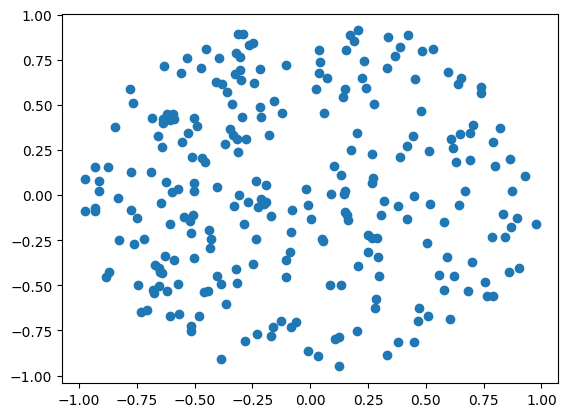

In [28]:
plt.scatter(data['pos'][:, 0], data['pos'][:, 1])

In [29]:
from torch_geometric.transforms import SamplePoints, KNNGraph

dataset.transform = T.Compose([SamplePoints(num=256), KNNGraph(k=6)])

data = dataset[0]
print(data)

Data(pos=[256, 3], y=[1], edge_index=[2, 1536])


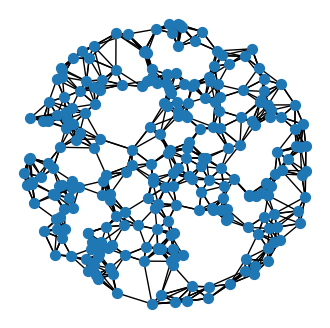

In [30]:
visualize_points(data.pos, edge_index=data.edge_index)

In [32]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing


class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super().__init__(aggr='max')

        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(Linear(in_channels + 3, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))

    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)  # Apply our final MLP.

In [33]:
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool


class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, dataset.num_classes)

    def forward(self, pos, batch):
        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)

        # 3. Start bipartite message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # 4. Global Pooling.
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]

        # 5. Classifier.
        return self.classifier(h)


model = PointNet()
print(model)

PointNet(
  (conv1): PointNetLayer()
  (conv2): PointNetLayer()
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)


**Important** the model does not generalize between different rotations applied to the input point cloud, because we train it on $p_j - p_i$

In [34]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

from torch_geometric.loader import DataLoader

train_dataset = GeometricShapes(root='data/GeometricShapes', train=True,
                                transform=SamplePoints(128))
test_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=SamplePoints(128))


train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

model = PointNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

def train(model, optimizer, loader):
    model.train()

    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        logits = model(data.pos, data.batch)  # Forward pass.
        loss = criterion(logits, data.y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        logits = model(data.pos, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 51):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Extracting data\GeometricShapes\raw.zip
Processing...
Done!


Epoch: 01, Loss: 3.7549, Test Accuracy: 0.0500
Epoch: 02, Loss: 3.7011, Test Accuracy: 0.0250
Epoch: 03, Loss: 3.6830, Test Accuracy: 0.0250
Epoch: 04, Loss: 3.6705, Test Accuracy: 0.0250
Epoch: 05, Loss: 3.6338, Test Accuracy: 0.0250
Epoch: 06, Loss: 3.5937, Test Accuracy: 0.0250
Epoch: 07, Loss: 3.5599, Test Accuracy: 0.0250
Epoch: 08, Loss: 3.4820, Test Accuracy: 0.0500
Epoch: 09, Loss: 3.4096, Test Accuracy: 0.0500
Epoch: 10, Loss: 3.3637, Test Accuracy: 0.0500
Epoch: 11, Loss: 3.2883, Test Accuracy: 0.0750
Epoch: 12, Loss: 3.2181, Test Accuracy: 0.1000
Epoch: 13, Loss: 3.1262, Test Accuracy: 0.1500
Epoch: 14, Loss: 3.0487, Test Accuracy: 0.1750
Epoch: 15, Loss: 2.9215, Test Accuracy: 0.1750
Epoch: 16, Loss: 2.8040, Test Accuracy: 0.2000
Epoch: 17, Loss: 2.6926, Test Accuracy: 0.3500
Epoch: 18, Loss: 2.5240, Test Accuracy: 0.3000
Epoch: 19, Loss: 2.4093, Test Accuracy: 0.4500
Epoch: 20, Loss: 2.1839, Test Accuracy: 0.2750
Epoch: 21, Loss: 2.1728, Test Accuracy: 0.4000
Epoch: 22, Lo